### Подключение библиотек

In [1]:
import numpy
import pandas
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
%matplotlib inline

### Используем обработанный датасет из прошлой домашней работы

In [2]:
dataset = pandas.read_csv("./NetflixNew.csv")
dataset.shape

(15480, 44)

### Разбиваем данные на обучающую и тестовую выборки

In [3]:
numpy.random.seed(7)
random_subset = numpy.random.choice(
    numpy.arange(dataset.shape[0]), size=10000, replace=False)
dataset = dataset.iloc[random_subset]
X = dataset.drop(['huge_boxoffice'], axis=1)
y = dataset['huge_boxoffice']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, random_state=9)
N_test, _ = X_test.shape

### Обучаем классификатор

In [4]:
mlp_model = MLPClassifier(hidden_layer_sizes=(50,),
                          solver='adam',
                          activation='relu',
                          random_state=17,
                          max_iter=1000)

In [5]:
%%time
mlp_model.fit(X_train, y_train)

Wall time: 1.31 s


MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=17)

In [6]:
y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

### Точность на выборках при использовании классификатора

In [7]:
print("TRAIN: {:.2f}% TEST: {:.2f}%".format(accuracy_score(y_train, y_train_pred)
      * 100, accuracy_score(y_test, y_test_pred) * 100))

TRAIN: 89.72% TEST: 89.23%


### Подбор параметра регуляризации `alpha`

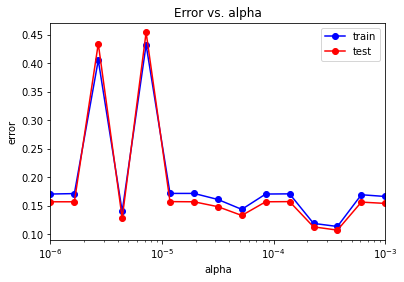

In [8]:
alpha_arr = numpy.logspace(-6, -3, 15)
test_err = []
train_err = []
train_acc = []
test_acc = []

for alpha in alpha_arr:
    mlp_model = MLPClassifier(alpha=alpha, hidden_layer_sizes=(50,),
                              solver='adam', activation='relu', max_iter=1000, random_state=9)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)

    train_err.append(numpy.mean(y_train != y_train_pred))
    test_err.append(numpy.mean(y_test != y_test_pred))
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))
plt.semilogx(alpha_arr, train_err, 'b-o', label='train')
plt.semilogx(alpha_arr, test_err, 'r-o', label='test')
plt.xlim([numpy.min(alpha_arr), numpy.max(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()

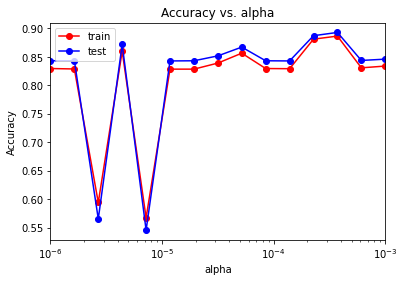

In [9]:
plt.semilogx(alpha_arr, train_acc, 'r-o', label='train')
plt.semilogx(alpha_arr, test_acc, 'b-o', label='test')
plt.xlim([numpy.min(alpha_arr), numpy.max(alpha_arr)])
plt.title('Accuracy vs. alpha')
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.legend()

По графику видно, что переобучения не наблюдается, точность на тестовой и тренировочной выборках практически совпадает. Также мы видим, что при некоторых значениях `alpha` точность резко падает, наблюдается недообучение.

In [10]:
min_train_err = numpy.min(train_err)
min_test_err = numpy.min(test_err)
print("TRAIN:", min_train_err, "TEST:", min_test_err)

TRAIN: 0.11353846153846153 TEST: 0.10714285714285714


In [11]:
alpha_opt = alpha_arr[test_err == min_test_err]
print("Alpha opt:", alpha_opt)

Alpha opt: [0.00037276]


In [12]:
mlp_model = MLPClassifier(alpha=alpha_opt[0], hidden_layer_sizes=(50,),
                          solver='adam', activation='relu', random_state=7)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

In [13]:
print("TRAIN: {:.2f}% TEST: {:.2f}%".format(accuracy_score(y_train, y_train_pred)
      * 100, accuracy_score(y_test, y_test_pred) * 100))

TRAIN: 86.09% TEST: 87.03%


In [14]:
print(confusion_matrix(y_test_pred, y_test))

[[2932  440]
 [  14  114]]


### Матрица рассогласования при оптимальном `alpha`

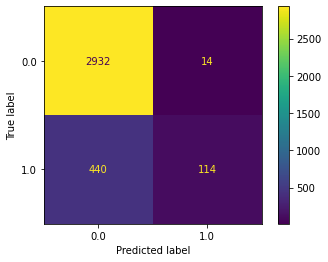

In [15]:
predictions = mlp_model.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=mlp_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp_model.classes_)
disp.plot()
plt.show()

### Подбор числа нейронов в скрытом слое

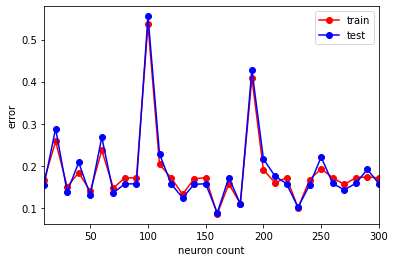

In [16]:
neuron_count_array = numpy.linspace(10, 300, 30).astype(int)
test_error = []
train_error = []
test_acc = []
train_acc = []

for neuron_count in neuron_count_array:
    model = MLPClassifier(
        alpha=alpha_opt,
        hidden_layer_sizes=(neuron_count,),
        solver='adam',
        activation='relu',
        max_iter=1000,
        random_state=7
    )
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    test_error.append(numpy.mean(y_test != y_test_pred))
    train_error.append(numpy.mean(y_train != y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))
    train_acc.append(accuracy_score(y_train, y_train_pred))
plt.plot(neuron_count_array, train_error, 'r-o', label='train')
plt.plot(neuron_count_array, test_error, 'b-o', label='test')
plt.xlim([numpy.min(neuron_count_array), numpy.max(neuron_count_array)])
plt.xlabel('neuron count')
plt.ylabel('error')
plt.legend()

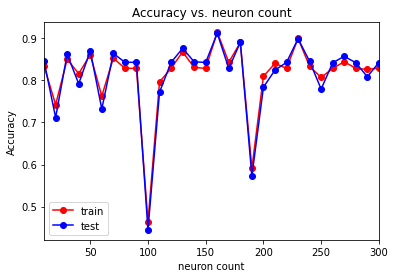

In [17]:
plt.plot(neuron_count_array, train_acc, 'r-o', label='train')
plt.plot(neuron_count_array, test_acc, 'b-o', label='test')
plt.xlim([numpy.min(neuron_count_array), numpy.max(neuron_count_array)])
plt.title('Accuracy vs. neuron count')
plt.xlabel('neuron count')
plt.ylabel('Accuracy')
plt.legend()

По графику видно, что переобучения не наблюдается, точность на тестовой и тренировочной выборках практически совпадает. Также мы видим, что при некоторых значениях количества нейронов точность резко падает, наблюдается недообучение, аналогично подбору коэффициента регуляризации.

In [18]:
min_test_error = numpy.min(test_error)
neuron_opt = neuron_count_array[test_error == min_test_error][0]
print('Optimal neuron count: {}'.format(neuron_opt))

Optimal neuron count: 160


In [19]:
mlp_model = MLPClassifier(alpha=alpha_opt[0], hidden_layer_sizes=(neuron_opt,),
                          solver='adam', activation='relu', max_iter=1000, random_state=42)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

In [20]:
print("TRAIN: {:.2f}% TEST: {:.2f}%".format(accuracy_score(y_train, y_train_pred)
      * 100, accuracy_score(y_test, y_test_pred) * 100))

TRAIN: 87.57% TEST: 88.06%


### Матрица рассогласования для модели с оптимальным `alpha` и числом нейронов, найденным зависимо от оптимального `alpha`

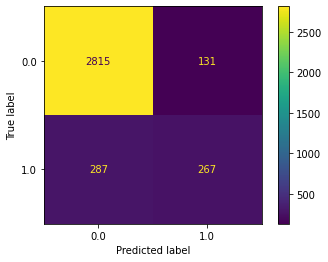

In [21]:
predictions = mlp_model.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=mlp_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp_model.classes_)
disp.plot()
plt.show()

### Одновременный подбор коэффициента регуляризации и числа нейронов

In [22]:
neuron_arr = numpy.linspace(50, 150, 5).astype(int)
alpha_arr = numpy.logspace(-3, -1, 5)
test_err = []
train_err = []
train_acc = []
test_acc = []
neuron_alpha_opt = []

for neuron in neuron_arr:
    for alpha in alpha_arr:
        mlp_model = MLPClassifier(alpha=alpha, hidden_layer_sizes=(neuron,),
                                  solver='adam', activation='relu', max_iter=1500, random_state=3)
        mlp_model.fit(X_train, y_train)

        y_train_pred = mlp_model.predict(X_train)
        y_test_pred = mlp_model.predict(X_test)

        train_err.append(numpy.mean(y_train != y_train_pred))
        test_err.append(numpy.mean(y_test != y_test_pred))
        train_acc.append(accuracy_score(y_train, y_train_pred))
        test_acc.append(accuracy_score(y_test, y_test_pred))
        neuron_alpha_opt.append([neuron, alpha])

In [23]:
min_test_err = numpy.min(test_err)
i, = numpy.where(test_err == min_test_err)
neuron_opt, alpha_opt = neuron_alpha_opt[i[0]]
print("Neuron count opt:", neuron_opt)
print("Alpha opt: ", alpha_opt)

Neuron count opt: 150
Alpha opt:  0.0031622776601683794


In [24]:
mlp_model = MLPClassifier(alpha=alpha_opt, hidden_layer_sizes=(neuron_opt,),
                          solver='adam', activation='relu', max_iter=1000, random_state=42)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

In [25]:
print("TRAIN: {:.2f}% TEST: {:.2f}%".format(accuracy_score(y_train, y_train_pred)
      * 100, accuracy_score(y_test, y_test_pred) * 100))

TRAIN: 86.52% TEST: 85.54%


Значения точности несколько изменились из-за подбора коэфиициентов в распределении точек.

### Матрица рассогласования для модели с оптимальным `alpha` и числом нейронов, найденным независимо от оптимального `alpha`

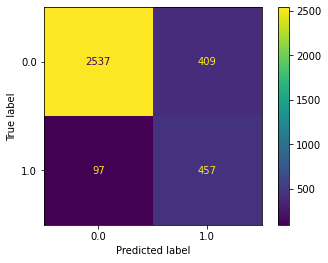

In [26]:
predictions = mlp_model.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=mlp_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp_model.classes_)
disp.plot()
plt.show()